<div align="right"><i>COM418 - Computers and Music</i></div>
<div align="right"><a href="https://people.epfl.ch/lucie.perrotta">Lucie Perrotta</a> and <a href="https://people.epfl.ch/paolo.prandoni">Paolo Prandoni</a>, <a href="https://www.epfl.ch/labs/lcav/">LCAV, EPFL</a></div>

<p style="font-size: 30pt; font-weight: bold; color: #B51F1F;">Dynamic Range Compression</p>

In [1]:
%matplotlib inline
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio
from scipy.io import wavfile

import matplotlib
figsize=(10,5)
plt.rcParams['figure.figsize'] = 14, 4 
matplotlib.rcParams.update({'font.size': 16})

In [2]:
def load_audio(filename):
    x_sf, x = wavfile.read(filename)
    x = (x - np.mean(x)) / 32767.0
    return x, x_sf

def multiplay(clips, sf, title=None):
    outs = [widgets.Output() for c in clips]
    for ix, item in enumerate(clips):
        with outs[ix]:
            print(title[ix] if title is not None else "")
            display(Audio(item, rate=sf, normalize=False))
    return widgets.HBox(outs)

# Introduction

<img src="img/RS124.jpg" alt="The RS124, the Beatles compressor at Abbey Road" style="float: right; width: 500px; margin: 20px 0px;"/>

A dynamic range compressor is a nonlinear device used to limit the amplitude excursion of an audio signal. The peak-to-peak range is reduced adaptively by applying a time-varying attenuation factor that depends on:
 * the desired amount of compression
 * the *reactivity* of the compressor to the input level
 * the target peak value
 

## Applications

Typical use cases include:
 * reduce spiky transients that would cause distortion (e.g. in recording electric bass)
 * compensate for varying distance between source and microphone
 * increase the overall loudness of a music piece

## Loudness

<img src="img/loudness.jpg" alt="loudness" style="float: right; width: 500px; margin: 20px 0px;"/>

 * perceptual loudness is related to RMS (average power)
 * dynamic range is related to peak amplitude (peak power)
 * PAPR: peak-to-average ratio
 * loud tracks have smaller PAPR values
 
A compressor reduces the PAPR so that the track sounds louder.

# A digital compressor

<img src="img/diagram.jpg" alt="diagram" style="width: 800px; margin: 20px 0px;"/>

A fully digital compressor applies a multiplicative gain factor to each input sample. The factor is computed in a *side chain* like so:
 
 * a theoretical instantaneous attenuation is computed for each sample
 * the attenuation is smoothed over time
 * a *make up* gain is used to boost the signal


## Linear to decibel (and back)

The compressor's sidechain works on a logarithmic amplitude scale, which better reflects the logarithmic nature of loudness perception. The amplitude unit used in the computation of the time-varying attenuation is the decibel; the attenuation is converted to linear units at the end of the sidechain processing.

For clarity, we will use lowercase letters for variables expressed in linear units and uppercase letters for variables in dBs.

In [3]:
def to_dB(x):
    EPS = 1e-10
    return 20 * np.log10(np.abs(x) + EPS)

def to_linear(X):
    return np.power(10, X / 20)

## The gain computer

The gain computer provides an instantaneous attenuation factor for each input sample; the sequence of raw gain values will be smoothed prior to application to the input signal  

### The waveshaper

The waveshaper determines an instantaneous attenuation factor for each input sample so that:
 * values below a threshold $T$ are left unchanged
 * values above $T$ are attenuated according to a parameter $C$
 * a transition region of width $W$ (aka the *soft knee*) provides a smooth transition between the two modes.

A common implemetation is as follows:

$$
\Gamma(X) = \begin{cases}
    X & \text{if } X - T < -W/2  & \text{ (below the soft-knee: no gain)} \\
    X + \displaystyle\frac{(1 - C)(X - T + W/2)^2}{2WC} & \text{if } |X - T| \leq W/2 & \text{ (inside the soft knee)}\\
    T + \displaystyle \frac{X - T}{C} & \text{if } X - T > W/2  &\text{ (above the soft knee: gain is less than unity)}
\end{cases}
$$

In [4]:
def waveshaper(x, T, C, W, linear_input=True):
    y = to_dB(x) if linear_input else np.copy(x) 
    if W > 0:
        y = np.where(2 * np.abs(x - T) <= W, x + (1 / C - 1) * (x - T + W / 2) ** 2 / (2 * W), y) # Soft-knee range
    y = np.where(2 * (x - T) > W, T + (x - T) / C,  y)                                        # Compression on range
    return y

In [5]:
def plot_gain(T=-30, C=4, W=10):
    fig, ax = plt.subplots(figsize=figsize)
    x = np.linspace(-100, 0, 2000)
    ax.plot(x, waveshaper(x, T, C, W, linear_input=False))
    ax.plot(x, x, alpha=.3, linestyle="dashed", color="gray")
    ax.grid(True)
    ax.set_xlim([-100, 0])
    ax.set_ylim([-100, 0])
    ax.axvline(T, label="threshold (T)", color="red")
    ax.axvspan(T-W/2, T+W/2, alpha=0.3, color='orange', label="transition band (W)")
    plt.xlabel("Input [dB]")
    plt.ylabel("Output [dB]")
    ax.legend(loc="best")
    plt.show()

In [6]:
widgets.interact(plot_gain, T=(-100, 0, 10), C=(1, 20, 1), W=(0, 30, 5));

interactive(children=(IntSlider(value=-30, description='T', max=0, min=-100, step=10), IntSlider(value=4, desc…

### The instantaneous attenuation

The per-sample attenuation determined by the waveshaper is $S[n] = X[n] - \Gamma(X[n])$. For values below the transition region, $S[n] = 0~\mathrm{dB}$.

Note that, in linear units, for input values past the threshold (and neglecting the knee), this corresponds to 

$$
  s[n] = \left(\frac{x[n]}{t}\right)^{C-1}
$$

When $C$ is greater that about 15, the waveshaper becomes in practice a hard limiter.

In [7]:
def inst_gain(x, T, C, W, linear_input=True):
    if linear_input:
        x = to_dB(x)
    return x - waveshaper(x, T, C, W, linear_input=False)

### Beware of pumping!

The instantaneous gain cannot be applied as such since its rapid variations would create an unpleasant effect known as "pumping", where the amplitude envelope of the signal changes too quickly over time

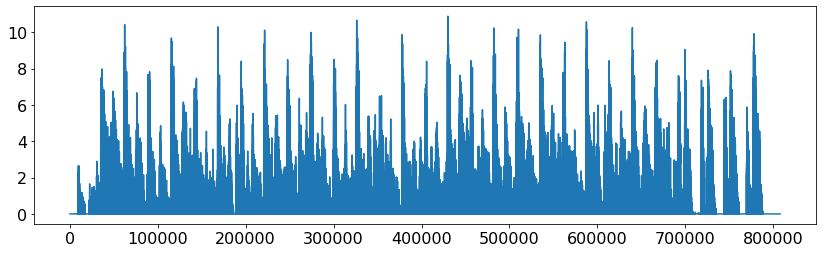

In [8]:
clip, clip_sf = load_audio("snd/groove.wav")

S = inst_gain(clip, -13, 10, 20, linear_input=True)
plt.plot(S);

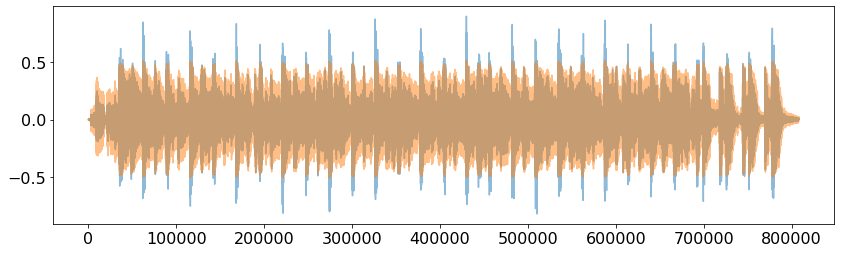

In [9]:
y = clip * to_linear(-S) * 2
plt.plot(clip, alpha=0.5)
plt.plot(y, alpha=0.5);

In [10]:
multiplay((clip, y), clip_sf, title=('original', 'compressed'))

## The gain smoother

In order to avoid distortion and pumping we need to:
 * apply the attenuation gradually, according to a user-definable *attack* time $\tau_A$
 * stop the attenuation gradually as well, with a rate of decay determined by a user-definable *release* time
 
To this end, the instantaneous attenuation $S[n]$ is averaged by a pair of leaky integrators as

$$
  G[n] = 
    \begin{cases}
        \lambda_A G[n-1] + (1-\lambda_A) S[n] & \text{if } S[n] > G[n-1] \\
        \lambda_R G[n-1] + (1-\lambda_R) S[n] &\text{if } S[n] \leq G[n-1]
    \end{cases}
$$

The coefficients $\lambda_A$ and $\lambda_R$ are related to the desired attack time $\tau_A$ and release time $\tau_R$ (expressed in seconds) as

$$
    \lambda_{A,R} = e^{-1/(\tau_{A,R}F_s)}
$$
where $F_s$ is the sampling rate of the system. Typical values for the time constants are  $10~\mathrm{ms} < \tau_A < 100~\mathrm{ms}$ and $100~\mathrm{ms} < \tau_R < 1000~\mathrm{ms}$.

In [11]:
def smoother(S, t_a, t_r, sf):
    # time constants are expressed in milliseconds
    l_a = np.exp(-1/(t_a * sf / 1000)) if t_a > 0 else 0
    l_r = np.exp(-1/(t_r * sf / 1000)) if t_r > 0 else 0
    G = np.zeros(len(S))
    for n in range(0, len(S)):
        lam = l_a if S[n] > G[n-1] else l_r
        G[n] = lam * G[n-1] + (1 - lam) * S[n]
    return G

In [12]:
def plot_smooth_gain(t_a=100, t_r=500):
    sf = 1000
    t = np.arange(0, 3 * sf) / sf
    X = -100 * np.ones(len(t)) 
    X[int(.5 * sf):int(1.5 * sf)] = 0
    G = smoother(inst_gain(X, -30, 4, 10, linear_input=False), t_a, t_r, sf)
    
    fig, ax = plt.subplots(figsize=figsize)

    ax.set_xlabel('time (s)')
    ax.set_ylabel('signal amplitude (dB)', color='C0')
    ax.plot(t, X, color='C0')

    ax2 = ax.twinx()  
    ax2.set_ylabel('attenuation (dB)', color='C1')  
    ax2.plot(t, G, color='C1')
    ax2.set_ylim(-1, 24)

In [13]:
widgets.interact(plot_smooth_gain, t_a=(0, 1000, 50), t_r=(0, 1000, 50));

interactive(children=(IntSlider(value=100, description='t_a', max=1000, step=50), IntSlider(value=500, descrip…

## The full chain


<img src="img/diagram.jpg" alt="diagram" style="width: 800px; margin: 20px 0px;"/>


The smoothed attenuation, when applied to the signal, will produce an output with a lower peak-to-average power ratio by reducing the peak-to-peak range of the input. This creates extra headroom that can be used to amplify the compressed signal and increase its power via a *make-up* gain factor $M$

In [14]:
def compressor(x, sf, T, C, W=10, M=0, t_a=100, t_r=500):
    G = smoother(inst_gain(x, T, C, W, linear_input=True), t_a, t_r, sf)
    return x * to_linear(M - G)

In [15]:
def interactive_comp(x, sf, T, C, W, M=0, t_a=10, t_r=500, play=False):
    y = compressor(x, sf, T, C, W, M, t_a, t_r)
    fig, ax = plt.subplots(figsize=figsize)
    t = np.arange(0, len(x)) / sf
    ax.plot(t, x, alpha=.5, label="original")
    ax.plot(t, y, alpha=.5, label="compressed")
    ax.axhline(to_linear(M + T), color="red", alpha=0.7)
    ax.axhline(-to_linear(M + T), color="red", alpha=0.7)
    plt.legend(loc="best")
    if play:
        return multiplay((x, y), sf, ('original', 'compressed'))

In [16]:
sf = 1000
t = np.arange(0, 3 * sf) / sf
x = np.sin(3 * t) * np.cos(np.pi / 10  * np.arange(0, len(t))) 
def inter_test():
    return widgets.interact(interactive_comp, x=widgets.fixed(x), sf=widgets.fixed(sf),
                 M=widgets.fixed(0), play=widgets.fixed(False), W=(0, 30, 5), 
                 T=widgets.IntSlider(min=-20, max=0, step=1, value=-6), C=(1, 20, 1),
                 t_a=(0, 100, 1), t_r=(0, 1000, 300));

In [17]:
inter_test();

interactive(children=(IntSlider(value=-6, description='T', max=0, min=-20), IntSlider(value=10, description='C…

# Examples

## Compressing speech

In [18]:
p, p_sf = load_audio("snd/speech.wav")
def inter_speech():
    return widgets.interact(interactive_comp, x=widgets.fixed(p), sf=widgets.fixed(p_sf), play=widgets.fixed(True), W=(0, 40, 35), 
                 T=widgets.IntSlider(min=-20, max=0, step=1, value=-16), C=widgets.IntSlider(min=4, max=20, step=1, value=13), 
                 M=widgets.IntSlider(min=0, max=20, step=1, value=11), 
                 t_a=widgets.IntSlider(min=0, max=100, step=1, value=0), t_r=(0, 1000, 700))

In [19]:
inter_speech();

interactive(children=(IntSlider(value=-16, description='T', max=0, min=-20), IntSlider(value=13, description='…

## Compressing bass

In [20]:
p, p_sf = load_audio("snd/bass.wav")
def inter_bass():
    return widgets.interact(interactive_comp, x=widgets.fixed(p), sf=widgets.fixed(p_sf), play=widgets.fixed(True), W=(0, 20, 5), 
                 T=widgets.IntSlider(min=-40, max=0, step=1, value=-25), C=widgets.IntSlider(min=4, max=20, step=1, value=8), 
                 M=widgets.IntSlider(min=0, max=20, step=1, value=16), 
                 t_a=widgets.IntSlider(min=0, max=500, step=1, value=1), t_r=widgets.IntSlider(min=0, max=1000, step=10, value=140));

In [21]:
inter_bass();

interactive(children=(IntSlider(value=-25, description='T', max=0, min=-40), IntSlider(value=8, description='C…